# Effects of Weather on Bicycle Traffic

## Prerequisites
### Required Packages

In [ ]:
%pip install SQLAlchemy
%pip install pandas
%pip install requests
%pip install plotly
%pip install nbconvert
%pip install statsmodels
%pip install kaleido

### Imports

In [2]:
## Imports
import os
import pandas as pd
import plotly.express as px
import numpy as np
import sqlalchemy as sql
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio

from IPython.display import display
from plotly.subplots import make_subplots, HTML

### Definitions
Functions and variables defined in here serve the purpose of increasing the readability of the report:

In [ ]:
## Collecting all required data from the database
def fetchData():
    engine = sql.create_engine("sqlite:///./data/data.sqlite")
    with engine.connect() as conn:
        startDate = "2021-01-01"
        ## Bicycle
        # Fetch data from the db
        df_cities = pd.read_sql("SELECT * FROM city", conn)
        df_bicycleStation = pd.read_sql("SELECT * FROM bicycle_station", conn)
        df_bicycleCount = pd.read_sql("SELECT * FROM bicycle_count", conn)

        # Form the data
        df_bicycleCount["timestamp"] = pd.to_datetime(df_bicycleCount["timestamp"]).dt.tz_convert(None)
        df_bicycleCount["count"] = df_bicycleCount["count"].astype(int)
        df_bicycleCount = df_bicycleCount.loc[df_bicycleCount["timestamp"] >= startDate]

        # Merge the data
        df = df_bicycleCount.merge(df_bicycleStation, left_on="bicycle_station_id", right_on="id", how="right").merge(df_cities, left_on="city_id", right_on="id", how="right")
        df.set_index("timestamp", inplace=True)

        # Group the data by station
        groupedBicycleByStation = df.groupby("bicycle_station_id")

        ## Weather
        # Fetch data from the db
        df_cities = pd.read_sql("SELECT * FROM city", conn)
        df_weatherStation = pd.read_sql("SELECT * FROM weather_station", conn)
        df_weatherEntry = pd.read_sql("SELECT * FROM weather_entry", conn)

        # Form the data
        df_weatherEntry["date"] = pd.to_datetime(df_weatherEntry["date"])
        df_weatherEntry = df_weatherEntry.loc[df_weatherEntry["date"] >= startDate]

        # Merge the data
        df = df_weatherEntry.merge(df_weatherStation, left_on="weather_station_id", right_on="id", how="right").merge(df_cities, left_on="city_id", right_on="id", how="right")
        df.set_index("date", inplace=True)

        # Group the data by station
        groupedWeatherByCity = df.groupby("city_id")

    return (groupedBicycleByStation, groupedWeatherByCity)


## Creating weekly and daily dfs for each weather station merged with bicycle counting stations
def prepareData(groupedBicycleByStation, groupedWeatherByCity):
    stationBicycleWeeklies = []
    stationBicycleDailies = []
    cityWeatherWeeklies = []

    for resolution, stationBicycleResolution, stationWeatherResolution in [
        ("W", stationBicycleWeeklies, cityWeatherWeeklies),
        ("D", stationBicycleDailies, []),
    ]:
        for city, df_cityWeather in groupedWeatherByCity:
            df_cityWeather = df_cityWeather.resample(resolution).agg(
                {
                    "tavg": "mean",
                    "tmin": "min",
                    "tmax": "max",
                    "prcp": "mean",
                    "snow": "mean",
                    "wdir": "mean",
                    "wspd": "mean",
                    "wpgt": "mean",
                    "pres": "mean",
                    "tsun": "mean",
                    "name": "first",
                    "city_id": "first",
                }
            )
            df_cityWeather.reset_index(inplace=True)
            df_cityWeather["date"] = pd.to_datetime(df_cityWeather["date"])
            stationWeatherResolution.append(df_cityWeather)

        for station, df_station in groupedBicycleByStation:
            df_station = df_station.resample(resolution).agg(
                {
                    "count": "sum",
                    "bicycle_station_id": "first",
                    "name_y": "first",
                    "name_x": "first",
                    "city_id": "first",
                }
            )
            df_station.reset_index(inplace=True)
            j = 0

            # Matching weather data to station
            for city in stationWeatherResolution:
                if df_station["city_id"].iloc[0] == city["city_id"].iloc[0]:
                    df_weather_weekly = city
                    break
                j += 1
            df_station = df_station.merge(
                stationWeatherResolution[j],
                left_on="timestamp",
                right_on="date",
                how="left",
            )
            # Add day of week
            df_station["day_of_week"] = df_station["timestamp"].dt.dayofweek + 1
            df_station["month"] = df_station["timestamp"].dt.month
            df_station["year"] = df_station["timestamp"].dt.year
            stationBicycleResolution.append(df_station)

    dfAllWeekly = pd.concat(stationBicycleWeeklies)
    dfAllDaily = pd.concat(stationBicycleDailies)

    return (
        stationBicycleWeeklies,
        stationBicycleDailies,
        cityWeatherWeeklies,
        dfAllWeekly,
        dfAllDaily,
    )


## Helper function for function below
def aggWeightedMean(df, column):
    return (df[column] * df["count"]).sum() / df["count"].sum()


## Calculates correlation for cities, summarizes counting stations by calculation a weighted average
def addCorrelation(df):
    stationNames = []
    cityNames = []
    columns = ["station_id"]

    for weatherType in weatherTypes:
        columns.append(f"{weatherType}_corr")
    dfCorr = pd.DataFrame(columns=columns)

    for city_df in df:
        stationNames.append(city_df["name_x"].iloc[0])
        cityNames.append(city_df["name_y"].iloc[0])
        new_row = pd.DataFrame({"station_id": [city_df["bicycle_station_id"].iloc[0]]})
        for weatherType in weatherTypes:
            correlation = city_df["count"].corr(city_df[weatherType])
            new_row[f"{weatherType}_corr"] = correlation
        dfCorr = pd.concat([dfCorr, new_row], ignore_index=True)
    cityNames = list(dict.fromkeys(cityNames))

    df = pd.concat(df).merge(dfCorr, left_on="bicycle_station_id", right_on="station_id", how="left")
    results = {}
    for column in columns[1:]:
        results[column] = df.groupby("city_id_y").apply(aggWeightedMean, column=column)
        results[column] = results[column].apply(lambda x: np.nan if x == 0 else x)
    return (pd.DataFrame(results), cityNames)


## Used to build custom subplots
def buildHTMLPlot():
    html = """
		<style>
		table, tr, td {
			background-color: white;
		}
		</style>
		'<table>'
		
		"""
    for i in range(2):
        html += "<tr>"
        for j in range(3):
            html += f'<td><img src="./data/figures/{weatherTypesSmall[i*3+j]}.png"></td>'
        html += "</tr>"
    html += "</table>"
    return HTML(html)


## Some definitions to make everything easier
weatherTypes = ["tavg", "tmax", "tmin", "tsun", "pres", "prcp", "wpgt", "snow", "wspd"]
weatherTypesSmall = ["tavg", "wspd", "tsun", "pres", "wdir", "prcp"]

weatherDict = {
    "prcp": "Precipitation",
    "wspd": "Wind speed",
    "tavg": "Average temperature",
    "wdir": "Wind direction",
    "wpgt": "Peak gust",
    "pres": "Pressure",
    "tsun": "Sunshine",
    "tmax": "Maximum temperature",
    "tmin": "Minimum temperature",
    "snow": "Snow",
}
weatherDictUnit = {
    "prcp": "Precipitation (mm)",
    "wspd": "Wind speed (m/s)",
    "tavg": "Average temperature (°C)",
    "wdir": "Wind direction (°)",
    "wpgt": "Peak gust (m/s)",
    "pres": "Pressure (hPa)",
    "tsun": "Sunshine (hours)",
}
weatherTypes = ["tavg", "tmax", "tmin", "tsun", "pres", "prcp", "wpgt", "snow", "wspd"]

# Sourced from:
# https://fahrradklima-test.adfc.de/fileadmin/BV/FKT/Download-Material/Ergebnisse_2022/ADFC-Fahrradklima-Test_2022_Ergebnistabelle_Druck_Gesamt_A3_230404.pdf
rank = {
    "Stadt Ludwigsburg": 3.64,
    "Landeshauptstadt Stuttgart": 4.2,
    "Stadt Heidelberg": 3.64,
    "Stadt Lörrach": 3.77,
    "Stadt Ulm": 3.96,
    "Stadt Freiburg": 3.11,
    "Stadt Konstanz": 3.27,
    "Stadt Tübingen": 3.12,
    "Landkreis Böblingen": 3.7,
    "Stadt Heilbronn": 3.82,
}

### Fetching and Preparing Data
`fetchData()` and `prepareData()` can be found in `.project/report_py`

In [3]:
groupedBicycleByStation, groupedWeatherByCity = fetchData()

In [4]:
## Creating weekly and daily dfs for each weather station merged with bicycle counting stations
(
    stationBicycleWeeklies,
    stationBicycleDailies,
    cityWeatherWeeklies,
    dfAllWeekly,
    dfAllDaily,
) = prepareData(groupedBicycleByStation, groupedWeatherByCity)

## Datasets

### Bicycle Traffic

Traffic data comes from [Mobilithek](https://mobilithek.info/offers/-5646868446023868292) and the data consists of **daily bicycle frequencies** of **57 measuring stations** in **13 cities** and communes across **Baden-Württemberg**, started on Jan. 2021, updated weekly.

Here is an overview (average frequencies observed per station and total of all stations since the beginning).

In [5]:
fig = make_subplots(
    rows=1,
    cols=4,
)
fig.add_trace(
    go.Bar(
        x=dfAllDaily.groupby("day_of_week")["count"].mean().index,
        y=dfAllDaily.groupby("day_of_week")["count"].mean(),
    )
)
fig.add_trace(
    go.Bar(
        x=dfAllDaily.groupby("month")["count"].mean().index,
        y=dfAllDaily.groupby("month")["count"].mean(),
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Bar(
        x=dfAllDaily.groupby("year")["count"].mean().index,
        y=dfAllDaily.groupby("year")["count"].mean(),
    ),
    row=1,
    col=3,
)
fig.add_trace(
    go.Bar(x=["2020 - 2023"], y=[dfAllDaily["count"].sum()]),
    row=1,
    col=4,
)
fig.update_layout(
    showlegend=False,
    height=300,
    margin=dict(b=10, t=10, pad=0),
)
# y axis
fig.update_yaxes(title_text="Average bicycle frequency", row=1, col=1)
fig.update_yaxes(matches="y1", row=1, col=2)
fig.update_yaxes(matches="y1", row=1, col=3)
fig.update_yaxes(title_text="Sum of bicycle count", side="right", row=1, col=4)
# x axis
fig.update_xaxes(title_text="Weekdays", row=1, col=1)
fig.update_xaxes(title_text="Months", row=1, col=2)
fig.update_xaxes(title_text="Years", row=1, col=3)
fig.update_xaxes(title_text="Total", row=1, col=4)

fig.show()

### Weather Data
This data is fetched from [Meteostat](https://dev.meteostat.net/bulk/daily.html) and consists of records of **daily weather parameters**(temperature, precipitation, snowfall, sunshine duration) of the same 13 cities. 

Here are two cities as example:

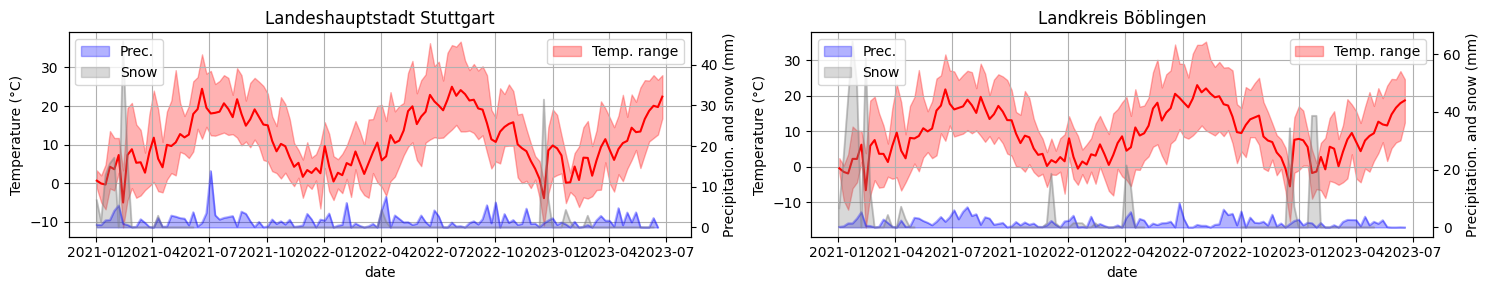

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs = axs.ravel()

for i, df_city_weekly in enumerate(cityWeatherWeeklies[:2]):
    axs[i].grid()

    # Temperature
    axs[i].plot(df_city_weekly["date"], df_city_weekly["tavg"], color="red")
    axs[i].fill_between(
        df_city_weekly["date"],
        df_city_weekly["tmin"],
        df_city_weekly["tmax"],
        color="red",
        alpha=0.3,
        label="Temp. range",
    )
    axs[i].set_xlabel("date")
    axs[i].set_ylabel("Temperature (°C)")
    axs[i].set_title(f"{df_city_weekly['name'].iloc[0]}")
    axs[i].legend(loc="upper right")

    # Precipitation and snow
    plt2 = axs[i].twinx()
    plt2.plot(df_city_weekly["date"], df_city_weekly["prcp"], color="blue", alpha=0.3)
    plt2.plot(df_city_weekly["date"], df_city_weekly["snow"], color="grey", alpha=0.3)

    plt2.fill_between(
        df_city_weekly["date"],
        df_city_weekly["prcp"],
        color="blue",
        alpha=0.3,
        label="Prec.",
    )
    plt2.fill_between(
        df_city_weekly["date"],
        df_city_weekly["snow"],
        color="grey",
        alpha=0.3,
        label="Snow",
    )
    plt2.set_ylabel("Precipitation. and snow (mm)")
    plt2.legend(loc="upper left")

fig.tight_layout()
plt.show()

## Combining Weather and Bicycle Counts
In order to explore the **potential relationship** between **weather conditions** and **bicycle counts**, we plotted **normalized** bicycle counts against the average temperature for each week. The **animation** below provides a visual representation of this relationship:

In [7]:
df = pd.concat(stationBicycleWeeklies).groupby(["city_id_x", "timestamp"]).agg({"count": "sum", "name_y": "first", "tavg": "first"}).reset_index()
df["Normalized count"] = df["count"]
df["Normalized count"] = df.groupby("city_id_x")["Normalized count"].transform(lambda x: round((x / x.max()) * 100))
df["count"] = df["count"].apply(lambda x: f"{round((int(x) / 1000), ndigits=2)}k")
df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%d")
df["Average temperature"] = df["tavg"]
fig = px.bar(
    data_frame=df,
    x="name_y",
    y=["Normalized count", "Average temperature"],
    animation_frame="timestamp",
    barmode="group",
    range_y=[0, 100],
)

for f in fig.frames:
    for t in f.data:
        t.textfont = dict(size=12)
        t.textangle = 0
        t.textposition = "inside"
        t.cliponaxis = False
        t.text = df["count"][df["timestamp"] == f.name]

for t in fig.data:
    if t.name == "Average temperature":
        t.text = df["Average temperature"]
        t.texttemplate = "%{y:.1f}°C"
        t.update(yaxis="y2")
        t.textposition = "outside"
    else:
        t.textfont = dict(size=12)
        t.textangle = 0
        t.textposition = "inside"
        t.cliponaxis = False
        t.text = df["count"][df["timestamp"] == f.name]

for f in fig.frames:
    for t in f.data:
        if t.name == "Average temperature":
            t.text = df["Average temperature"]
            t.texttemplate = "%{y:.1f}°C"
            t.update(yaxis="y2")
            t.textposition = "outside"

fig.update_layout(
    height=600,
    yaxis_title="Bicycle Frequency to City Maximum (%)",
    yaxis2=dict(
        title="Average Temperature (°C)",
        overlaying="y",
        side="right",
        range=[-10, 25],
        showgrid=False,
    ),
    xaxis=dict(
        title="Cities",
        tickangle=10,
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    legend_title="",
    hovermode="x unified",
)
fig.show()

We observe behaviour that implies some sort of **correlation** between **temperature** and **traffic**. So let's continue:
## What Correlation Have Certain Weather Conditions with the Frequency of Bicycle Traffic?

We plot the correlation of single weather parameters to bicycle counts for each city **grouped by week**. As there are multiple counting stations located in each city, we first calculate the **correlation for each station** and then **weight** them **by importance** (according to the frequency) and calculate a **city wide average**:

In [8]:
df, cityNames = addCorrelation(stationBicycleWeeklies)

fig1 = px.imshow(
    df.T,
    y=[weatherDict[x] for x in weatherTypes],
    x=cityNames,
    color_continuous_scale="RdBu",
)
fig1.update_xaxes(tickangle=30)
fig1.update_layout(
    title=dict(
        font=dict(size=20),
        automargin=True,
        yref="paper",
    ),
    xaxis_title="",
)
fig1.show()

df_for_later = df.copy()

We can observe that conditions like the **temperature**, or **sun hours** have sometimes a very high **positive correlation** with the bicycle frequency, while the **speed of wind** and **snow** have a moderate to low **negative correlation** with the frequency.

The **perception** seems to have **very low correlation** with the weekly traffic counts.

The **correlation differs between cities** noticeable. While *Freiburg* only correlates moderate (lowest in total), the city *Ulm* correlates the most.
We will investigate possible causes of these phenomena later on. But first, we will have a look at specific weather conditions. 

### Do Weekends Affect the Correlation?

We are broadening our level of granularity to **focus on individual days**. We will calculate the **average bicycle frequency** for specific value ranges of **weather parameters** (for instance, this approach allows us to observe the average behaviour of bicycle frequency when the temperature ranges between 20-25 °C). This also enables us to differentiate based on the **type of day** (weekday, weekend):


In [9]:
df = stationBicycleDailies

# Separating day types
df = pd.concat(df)
df1 = df[df["timestamp"].dt.dayofweek.isin([0, 1, 2, 3, 4])]
df2 = df[df["timestamp"].dt.dayofweek.isin([5, 6])]

# Building a custom subplot because plotly subplots did not work
for file in os.listdir("./data/figures/"):
    os.remove(f"./data/figures/{file}")

for weatherType in weatherTypesSmall:
    df = pd.concat([df1, df2])
    df["day"] = np.where(df["timestamp"].dt.dayofweek.isin([5, 6]), "Weekend", "Weekday")

    if weatherType == "prcp":
        df = df[df["prcp"] < 2000]

    fig = px.histogram(
        df,
        x=weatherType,
        y="count",
        histfunc="avg",
        color="day",
        nbins=20,
        opacity=0.75,
        barmode="overlay",
    )

    fig.update_layout(
        xaxis_title=weatherDictUnit[weatherType],
        yaxis_title=None,
        legend_title=None,
        showlegend=False,
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        font=dict(
            size=24,
        ),
    )
    fig.update_yaxes(range=[0, 4999], showticklabels=False)

    if weatherType == "tsun":
        fig.update_layout(showlegend=True)

    if weatherType in ["tavg", "pres"]:
        fig.update_layout(
            xaxis_title=weatherDictUnit[weatherType],
            yaxis_title="Average Bicycle Frequency",
        )
        fig.update_yaxes(showticklabels=True)

    pio.write_image(fig, f"./data/figures/{weatherType}.png")


# Displaying subplot with HTML
display(buildHTMLPlot())

First and foremost, **weekends** come hand in hand with **less bicycle traffic**.

The **potential positive effect** of **temperature on traffic** continues in this graph, as well as the **potential negative effect** of **wind speed**. 
However, there are signs for a new correlation not visible before: **bicycle traffic** has some **correlation** with the **wind direction** in our dataset. The average traffic rises in the region “north” and “south-west”. We were not able to identify possible reasons for this behaviour. One hypothesis would be that these wind directions relate to better weather in Baden-Württemberg.

Also, this graph shows that we have not enough data points in our data set for days with heavy rain.

Next we want to know, how weather correlates with traffic on weekends compared to weekdays:


In [10]:
### Compare weekdays to weekends

fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Weekdays", "Weekends"))

for idx, days in enumerate([[0, 1, 2, 3, 4], [5, 6]]):
    df = [df_city[df_city["timestamp"].dt.dayofweek.isin(days)] for df_city in stationBicycleDailies]
    df, cityNames = addCorrelation(df)

    if idx == 0:
        fig.add_trace(
            go.Heatmap(
                z=df.T,
                x=cityNames,
                y=weatherTypes,
                colorscale="RdBu",
                colorbar=dict(y=0.5, len=1.2),
            ),
            row=1,
            col=idx + 1,
        )
    else:
        fig.add_trace(
            go.Heatmap(
                z=df.T,
                x=cityNames,
                y=weatherTypes,
                colorscale="RdBu",
                colorbar=dict(
                    y=0.5,
                    len=1.2,
                    tickvals=[-0.4, 0.8],
                ),
            ),
            row=1,
            col=idx + 1,
        )

fig.update_layout(
    title=dict(
        text="Correlation Between Weather Effects and Daily Bicycle Frequency in Cities (Weighted Average)",
    ),
    xaxis_title=None,
)
fig.update_yaxes(autorange="reversed")

fig.show()

The positive and negative correlations are higher on weekends. Hypothetical, people might choose their activities of transport more weather oriented on weekends, because they are not mandatory, while many mandatory activities occur on weekdays.

# Why Does Some Cities Bicycle Traffic Seem More Resilient to Weather than Others?
To answer this question, we look at the [infrastructure ranking from ADFC (2022)](https://fahrradklima-test.adfc.de/fileadmin/BV/FKT/Download-Material/Ergebnisse_2022/ADFC-Fahrradklima-Test_2022_Ergebnistabelle_Druck_Gesamt_A3_230404.pdf) and map the rating to each city, then look, if the weather-bicycle-correlation correlates with the ranking. To only include meaningful weather-bicycle correlations, we average the [average temperature and the wind correlation of each city](#weeklyCorr).


In [12]:
df = df_for_later.copy()
j = 0

for i, row in df.iterrows():
    df.loc[i, "rank"] = rank[cityNames[j]]
    df.loc[i, "name"] = cityNames[j]
    j += 1
df["total"] = df[["wspd_corr", "tavg_corr"]].abs().mean(axis=1)

df.sort_values(by="total", ascending=False, inplace=True)
df.reset_index(inplace=True)
for i, row in df.iterrows():
    df.loc[i, "corr_rank"] = i + 1
# Hacky way to let text not overlap
df.replace({"Stadt Heidelberg": "Heidlberg          ", "Stadt Lörrach": "      Lörrach", "Tübingen": "Tübingen"}, inplace=True)

fig = px.scatter(
    df,
    x="total",
    y="rank",
    size="total",
    color="rank",
    text="name",
    color_continuous_scale="Viridis_r",
    trendline="ols",
    title=f"corr = {round(df['rank'].corr(df['total']), 2)}",
    labels={
        "total": "Weather-bicycle correlation",
        "rank": "Infrastructure rating (lower is better)",
    },
)
fig.update_traces(textposition="top center")
fig.update_layout(coloraxis_showscale=False)
fig = go.Figure(fig)

fig.show()

With **0.94**, the quality of **bicycle infrastructure** **correlates very highly** with the **bicycle frequency**. A possible reason could be the positive effect of good infrastructure on cycling popularity. Hypothetical, this could show that bad weather affects the popularity of cycling, but good cycling infrastructure combats the effect. This could potentially be the reason *Freiburg's* bicycle traffic is less correlating with weather than other cities, as it is on rank 1 in the nation wide [city ranking from ADFC (only infrastructure)](https://fahrradklima-test.adfc.de/fileadmin/BV/FKT/Download-Material/Ergebnisse_2022/ADFC-Fahrradklima-Test_2022_Ergebnistabelle_Druck_Gesamt_A3_230404.pdf).

Conclusion: Investing in cycling infrastructure is always good ;)